# Определение стоимости автомобилей для «Не бит, не крашен»

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нем можно быстро узнать рыночную стоимость своего автомобиля.

**Цель исследования:** построение модели для определения рыночной стоимости автомобиля

Заказчик предоставляет в распоряжение исторические данные, содержащие технические характеристики, комплектации и цены автомобилей.

**Заказчику важны следующие показатели:**
1. Качество предсказания
2. Скорость предсказания
3. Время обучения

**Этапы исследования:**
1. Загрузка и обзор данных
2. Предобработка данных
3. Подготовка данных для обучения моделей
4. Обучение моделей
5. Анализ времени обучения, времени предсказания и качества моделей
6. Выбор лучшей модели
7. Написание общего вывода

## Загрузка данных

Установим и импортируем необходимые для исследования библиотеки:

In [1]:
#!pip install scikit-learn==1.6 -q

In [62]:
import pandas as pd
import numpy as np
from numpy.random import RandomState
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder,
    MinMaxScaler
)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import time

Откроем файл с датасетом:

In [3]:
try:
    autos = pd.read_csv('/datasets/autos.csv')
except:
    autos = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

Выведем первые строки и общую информацию о датасете `autos`:

In [4]:
autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Датасет содержит следующие данные:
* `DateCrawled` - дата скачивания анкеты из базы
* `VehicleType` - тип автомобильного кузова
* `RegistrationYear` - год регистрации автомобиля
* `Gearbox` - тип коробки передач
* `Power` - мощность (л.с.)
* `Model` - модель автомобиля
* `Kilometer` - пробег (км)
* `RegistrationMonth` - месяц регистрации автомобиля
* `FuelType` - тип топлива
* `Brand` - марка автомобиля
* `Repaired` - была машина в ремонте или нет
* `DateCreated` - дата создания анкеты
* `NumberOfPictures` - количество фотографий автомобиля
* `PostalCode` - почтовый индекс владельца анкеты (пользователя)
* `LastSeen` - дата последней активности пользователя
* `Price` - цена (евро), целевой признак

Определим функцию для отображения информации о датасете:

In [5]:
def get_info(df):
    print(df.info())
    print(50 * '-')
    display(df.describe().T)

Выведем информацию о датасете `autos`:

In [6]:
get_info(autos)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


В датафрейме имеются пропуски данных, а также некорректные значения и аномалии в столбцах, поэтому необходима предобработка данных.

## Предобработка и исследовательский анализ данных

Посчитаем количество и долю пропусков в данных:

In [7]:
autos.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [8]:
round(autos.isna().mean() * 100, 2)

DateCrawled           0.00
Price                 0.00
VehicleType          10.58
RegistrationYear      0.00
Gearbox               5.60
Power                 0.00
Model                 5.56
Kilometer             0.00
RegistrationMonth     0.00
FuelType              9.28
Brand                 0.00
Repaired             20.08
DateCreated           0.00
NumberOfPictures      0.00
PostalCode            0.00
LastSeen              0.00
dtype: float64

Пропуски данных имеют пять столбцов, доля пропусков достаточно высокая, чтобы просто удалить эти данные из датафрейма. Далее попробуем решить проблему с пропусками.

Определим функцию для нахождения категориальных и количественных признаков в датафрейме:

In [9]:
def get_columns(df):
    return {
        'cat_col_names': df.select_dtypes(exclude='number').columns.tolist(),
        'num_col_names': df.select_dtypes(include='number').columns.tolist()
    }

Произведем проверку текстовых столбцов датафрейма (за исключением дат) на наличие неявных дубликатов и пропусков данных:

In [10]:
get_columns(autos)['cat_col_names']

['DateCrawled',
 'VehicleType',
 'Gearbox',
 'Model',
 'FuelType',
 'Brand',
 'Repaired',
 'DateCreated',
 'LastSeen']

Проверим значения в столбце `VehicleType`:

In [11]:
autos['VehicleType'].sort_values().unique().tolist()

['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv', 'wagon', nan]

Неявных дубликатов в типах автомобильного кузова не выявлено, пропуски заменим на значение `other`:

In [12]:
autos['VehicleType'] = autos['VehicleType'].fillna('other')

Проверим значения в столбце `Gearbox`:

In [13]:
autos['Gearbox'].sort_values().unique().tolist()

['auto', 'manual', nan]

Неявных дубликатов в типах коробки передач не выявлено. Заполнять пропуски по моде некорректно, т.к. одни и те же модели автомобилей могут иметь разные типы КПП в зависимости от комплектации. Поэтому заменим пропуски на `unknown`:

In [14]:
autos['Gearbox'] = autos['Gearbox'].fillna('unknown')

Проверим значения в столбце `Model`:

In [15]:
print(autos['Model'].sort_values().unique().tolist())

['100', '145', '147', '156', '159', '1_reihe', '1er', '200', '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe', '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900', '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8', 'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea', 'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo', 'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora', 'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse', 'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma', 'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee', 'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo', 'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma', 'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery', 'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos', 'escort', 'espace', 'exeo', 'fabia', 'fiesta', 'focus', 'forester', 'forfour', 'fortwo', 'fox', 'freelander', 'fusion', 

Неявных дубликатов в моделях автомобилей не выявлено. Как и в предыдущем случае заменим пропуски на `unknown`:

In [16]:
autos['Model'] = autos['Model'].fillna('unknown')

Проверим значения в столбце `FuelType`:

In [17]:
autos['FuelType'].sort_values().unique().tolist()

['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol', nan]

Неявных дубликатов в типах топлива не выявлено, заменим пропуски на имеющееся в списке значение `other`:

In [18]:
autos['FuelType'] = autos['FuelType'].fillna('other')

В столбце `FuelType` некоторые категории можно объединить:

In [19]:
autos['FuelType'] = autos['FuelType'].replace('gasoline', 'petrol')

Проверим значения в столбце `Brand`:

In [20]:
print(autos['Brand'].sort_values().unique().tolist())

['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen', 'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai', 'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda', 'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot', 'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart', 'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant', 'volkswagen', 'volvo']


Неявных дубликатов в марках автомобилей не выявлено.

Проверим значения в столбце `Repaired`:

In [21]:
autos['Repaired'].sort_values().unique().tolist()

['no', 'yes', nan]

Неявных дубликатов в столбце не выявлено. Имеющиеся пропуски данных логичнее заменить на значение `no`, т. к., возможно, автомобилисты просто не указывали этот параметр в случае, если их автомобиль не был в ремонте:

In [22]:
autos['Repaired'] = autos['Repaired'].fillna('no')

Далее произведем проверку числовых столбцов датафрейма на наличие аномалий и некорректных данных.

In [23]:
get_columns(autos)['num_col_names']

['Price',
 'RegistrationYear',
 'Power',
 'Kilometer',
 'RegistrationMonth',
 'NumberOfPictures',
 'PostalCode']

Для отображения количественных признаков из датафреймов в виде гистограмм и диаграмм размаха ("ящик с усами") определим функцию:

In [24]:
def show_graph_1(data, column, hist_title, box_title, xlabel):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    histplot = sns.histplot(
        data=data,
        x=column,
        bins=50,
        color='darkcyan',
        kde=True,
        ax=axes[0]
    )
    histplot.set(
        title=hist_title,
        xlabel=xlabel,
        ylabel='Количество'
    )
    boxplot = sns.boxplot(
        data=data,
        x=column,
        color='salmon',
        ax=axes[1]
    )
    boxplot.set(
        title=box_title,
        xlabel=xlabel
    )

Отобразим гистограмму и "ящик с усами" для столбца `Price`:

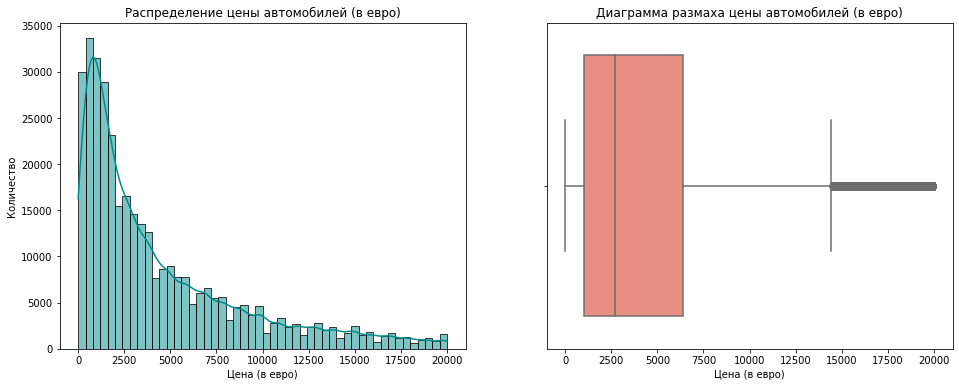

In [25]:
show_graph_1(
    autos,
    'Price',
    'Распределение цены автомобилей (в евро)',
    'Диаграмма размаха цены автомобилей (в евро)',
    'Цена (в евро)'
)

Цена автомобиля меньше 100 евро вызывает подозрение, там более нулевая цена - таких данных не должно быть в датафрейме. С другой стороны, имеются очень дорогие автомобили, но тут каждый владелец вправе устанавливать цену выше средней цены в зависимости от различных факторов. Поэтому удалим из датафрейма строки с ценой автомобиля меньше 100 евро:

In [26]:
autos = autos[autos['Price'] >= 100]

Отобразим гистограмму и "ящик с усами" для столбца `RegistrationYear`:

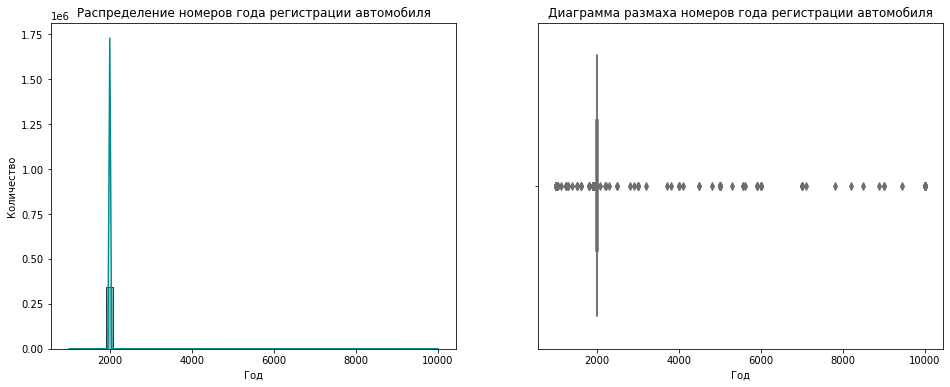

In [27]:
show_graph_1(
    autos,
    'RegistrationYear',
    'Распределение номеров года регистрации автомобиля',
    'Диаграмма размаха номеров года регистрации автомобиля',
    'Год'
)

Много данных с явно некорректным годом регистрации автомобиля. Ограничим этот параметр логичным диапазоном от 1900 до 2025 года и отобразим гистограмму и "ящик с усами":

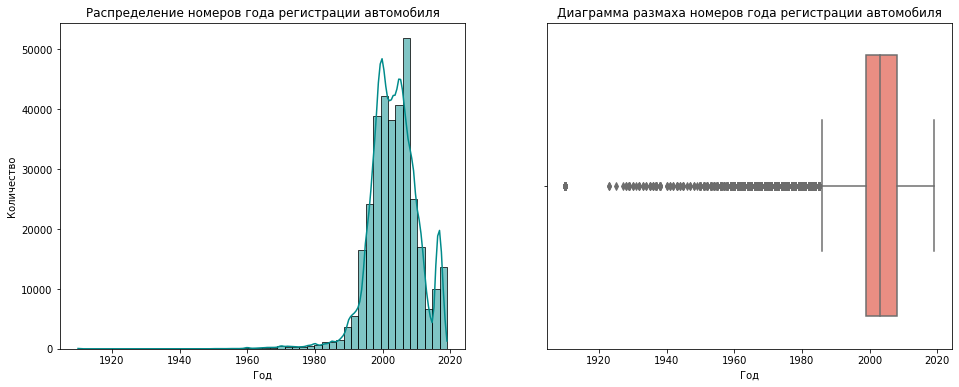

In [28]:
show_graph_1(
    autos[(autos['RegistrationYear'] >= 1900) & (autos['RegistrationYear'] <= 2025)],
    'RegistrationYear',
    'Распределение номеров года регистрации автомобиля',
    'Диаграмма размаха номеров года регистрации автомобиля',
    'Год'
)

По полученной гистограмме виден длинный "хвост" до 1980 года, который по идее можно отсечь без значимой потери данных. Проверим, какая доля данных в этом "хвосте":

In [29]:
ry_1900_1980 = autos[(autos['RegistrationYear'] >= 1900) & (autos['RegistrationYear'] < 1980)]
ry_1900_2025 = autos[(autos['RegistrationYear'] >= 1900) & (autos['RegistrationYear'] <= 2025)]
print(f'Доля - {(len(ry_1900_1980) / len(ry_1900_2025)):.2%}')

Доля - 0.89%


Доля таких строк менее 1%, поэтому можно усекать исходные данные диапазоном 1980-2025 гг.:

In [30]:
autos = autos[(autos['RegistrationYear'] >= 1980) & (autos['RegistrationYear'] <= 2025)]

Отобразим гистограмму и "ящик с усами" для столбца `Power`:

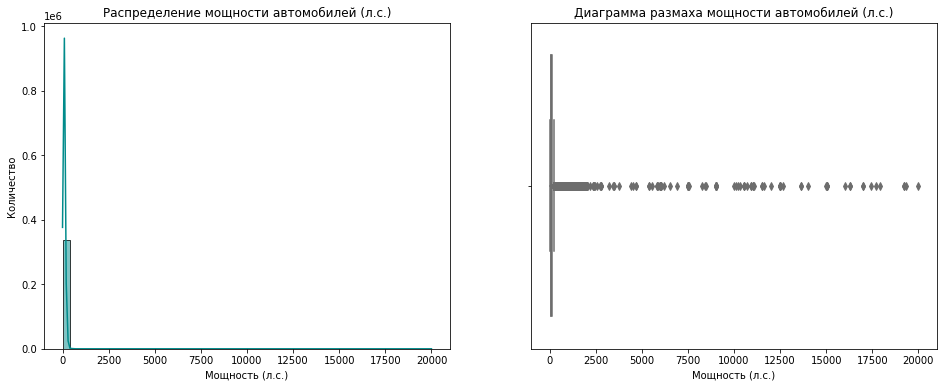

In [31]:
show_graph_1(
    autos,
    'Power',
    'Распределение мощности автомобилей (л.с.)',
    'Диаграмма размаха мощности автомобилей (л.с.)',
    'Мощность (л.с.)'
)

Здесь так же много данных с явно некорректным значением мощности автомобиля - имеются данные как по автомобилям с нулевой мощностью, так и по автомобилям с явно завышенной мощностью. Ограничим этот параметр логичным диапазоном мощности серийных автомобилей - больше 30 и меньше 300:

In [32]:
autos = autos[(autos['Power'] >= 30) & (autos['Power'] <= 300)]

Проверим полученные данные с помощью гистограммы и "ящика с усами":

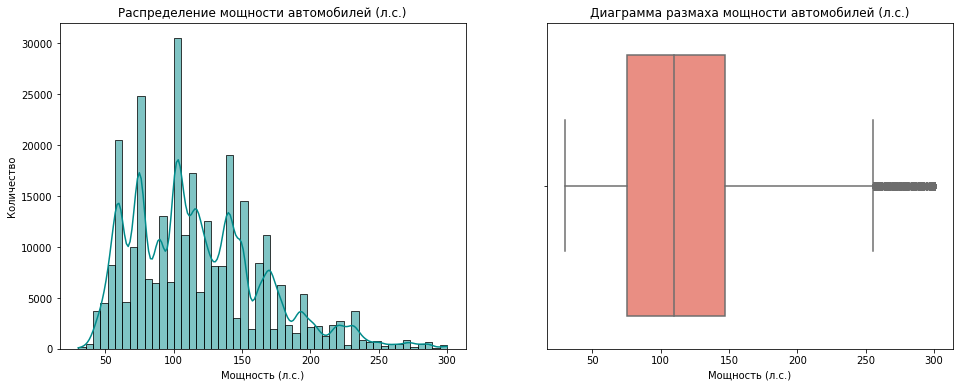

In [33]:
show_graph_1(
    autos,
    'Power',
    'Распределение мощности автомобилей (л.с.)',
    'Диаграмма размаха мощности автомобилей (л.с.)',
    'Мощность (л.с.)'
)

Отобразим гистограмму и "ящик с усами" для столбца `Kilometer`:

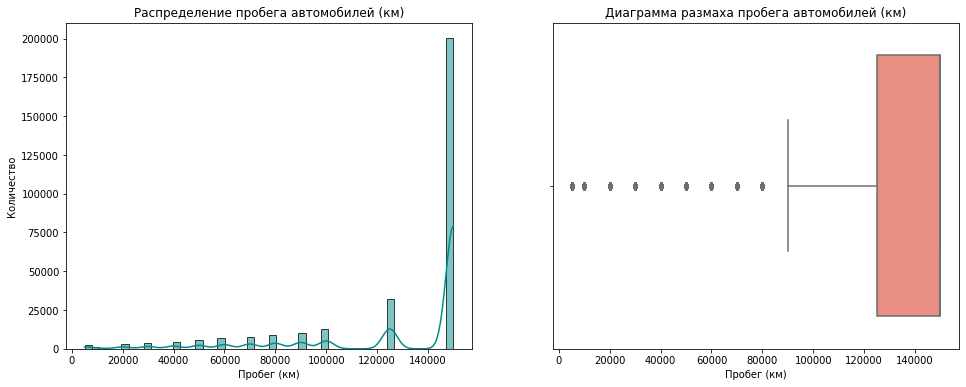

In [34]:
show_graph_1(
    autos,
    'Kilometer',
    'Распределение пробега автомобилей (км)',
    'Диаграмма размаха пробега автомобилей (км)',
    'Пробег (км)'
)

По пробегу никаких аномалий выявлено не было, большая часть автомобилей имеет пробег более 100000 км.

Для столбцов `RegistrationMonth`, `NumberOfPictures` и `PostalCode` нет смысла проводить аналогичный анализ, т.к. эти данные в дальнейшем не будут участовать в построении модели.

Проверим данные на наличие явных дубликатов:

In [35]:
autos.duplicated().sum()

5

Удалим из датафрейма обнаруженные 5 явных дубликатов:

In [36]:
autos = autos.drop_duplicates()

Данные подготовлены для формирования выборок и обучения моделей.

## Подготовка данных для обучения моделей

Удалим из датасета неактуальные столбцы:

In [37]:
autos = autos.drop([
    'DateCrawled',
    'RegistrationMonth',
    'DateCreated',
    'NumberOfPictures',
    'PostalCode',
    'LastSeen'
], axis=1)

После удаления неактульных данных повторно проверим наличие дубликатов:

In [38]:
autos.duplicated().sum()

46361

Удалим вновь образовавшиеся дубликаты:

In [39]:
autos = autos.drop_duplicates()

Определим переменные:

In [40]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

Сформируем тренировочные и тестовые выборки:

In [41]:
X = autos.drop('Price', axis=1)
y = autos['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_train: (190098, 9)
X_test: (63366, 9)
y_train: (190098,)
y_test: (63366,)


## Обучение моделей

Используя пайплайны, применим следующие модели:
* Модель LinearRegression (линейная регрессия)
* Модель LightGBMRegressor (деревья принятия решений с градиентным бустингом)
* Модель CatBoostRegressor (градиентный бустинг)

Создадим списки с названиями признаков:

In [42]:
ohe_columns = ['VehicleType', 'Gearbox', 'FuelType', 'Brand']
ord_columns = ['Repaired', 'Model']
num_columns = ['RegistrationYear', 'Power', 'Kilometer']

Создадим пайплайны для подготовки признаков:

In [43]:
ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

In [44]:
ord_pipe = Pipeline([
    ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord', OrdinalEncoder(
        categories=[
            ['no', 'yes'],
            X['Model'].sort_values().unique().tolist()
        ],
        handle_unknown='use_encoded_value',
        unknown_value=np.nan)
    ),
    ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

In [45]:
num_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('minmax', MinMaxScaler())
])

Создадим общий пайплайн для обработки данных:

In [46]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', num_pipe, num_columns)
    ], 
    remainder='passthrough'
)

### Модель LinearRegression

Создадим итоговый пайплайн - подготовка данных и модель:

In [47]:
pipe_final_lr = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

Создадим словарь со значениями гиперпараметров:

In [48]:
param_grid_lr = [
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

Для поиска лучшей модели будем использовать GridSearchCV:

In [49]:
gs_lr = GridSearchCV(
    pipe_final_lr, 
    param_grid_lr, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

gs_lr.fit(X_train, y_train)
lr_train_rmse = (-1) * gs_lr.best_score_
lr_train_time = gs_lr.cv_results_['mean_fit_time'].mean()

print(f'Лучшая модель и ее параметры:\n\n {gs_lr.best_estimator_}')
print(f'Метрика RMSE лучшей модели на кросс-валидации: {lr_train_rmse}')
print(f'Среднее время обучения: {lr_train_time} сек.')

Лучшая модель и ее параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'FuelType', 'Brand']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                       

Рассчитаем время предсказания на тренировочной выборке:

In [50]:
%%time

start = time.time()
y_pred = gs_lr.best_estimator_.predict(X_train)
end = time.time()
lr_pred_time = end - start
print(f'Время предсказания {lr_pred_time} сек.')

Время предсказания 0.3680758476257324 сек.
CPU times: user 345 ms, sys: 9.76 ms, total: 355 ms
Wall time: 368 ms


### Модель LGBMRegressor

Создадим итоговый пайплайн - подготовка данных и модель:

In [51]:
pipe_final_lgbmr = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LGBMRegressor(random_state=RANDOM_STATE, verbose=-1))
])

Создадим словарь со значениями гиперпараметров:

In [52]:
param_grid_lgbmr = [
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE, verbose=-1)],
        'models__n_estimators': range(90, 100, 10),#range(50, 100, 10)
        'models__max_depth': range(7, 8),#range(3, 8)
        'models__num_leaves': range(40, 50, 10),#range(5, 50, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

Для поиска лучшей модели будем использовать GridSearchCV:

In [53]:
gs_lgbmr = GridSearchCV(
    pipe_final_lgbmr, 
    param_grid_lgbmr, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=5
)

gs_lgbmr.fit(X_train, y_train)
lgbmr_train_rmse = (-1) * gs_lgbmr.best_score_
lgbmr_train_time = gs_lgbmr.cv_results_['mean_fit_time'].mean()

print(f'Лучшая модель и ее параметры:\n\n {gs_lgbmr.best_estimator_}')
print(f'Метрика RMSE лучшей модели на кросс-валидации: {lgbmr_train_rmse}')
print(f'Среднее время обучения {lgbmr_train_time} сек.')

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mix

[CV 1/5] END models=LGBMRegressor(random_state=42, verbose=-1), models__max_depth=7, models__n_estimators=90, models__num_leaves=40, preprocessor__num=StandardScaler();, score=-1669.217 total time=  37.8s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRe

[CV 2/5] END models=LGBMRegressor(random_state=42, verbose=-1), models__max_depth=7, models__n_estimators=90, models__num_leaves=40, preprocessor__num=StandardScaler();, score=-1685.138 total time= 2.8min


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRe

[CV 3/5] END models=LGBMRegressor(random_state=42, verbose=-1), models__max_depth=7, models__n_estimators=90, models__num_leaves=40, preprocessor__num=StandardScaler();, score=-1729.554 total time=  51.6s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRe

[CV 4/5] END models=LGBMRegressor(random_state=42, verbose=-1), models__max_depth=7, models__n_estimators=90, models__num_leaves=40, preprocessor__num=StandardScaler();, score=-1695.073 total time= 3.2min


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRe

[CV 5/5] END models=LGBMRegressor(random_state=42, verbose=-1), models__max_depth=7, models__n_estimators=90, models__num_leaves=40, preprocessor__num=StandardScaler();, score=-1696.265 total time=  47.0s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRe

[CV 1/5] END models=LGBMRegressor(random_state=42, verbose=-1), models__max_depth=7, models__n_estimators=90, models__num_leaves=40, preprocessor__num=MinMaxScaler();, score=-1670.307 total time=  43.3s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRe

[CV 2/5] END models=LGBMRegressor(random_state=42, verbose=-1), models__max_depth=7, models__n_estimators=90, models__num_leaves=40, preprocessor__num=MinMaxScaler();, score=-1688.320 total time=  40.8s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRe

[CV 3/5] END models=LGBMRegressor(random_state=42, verbose=-1), models__max_depth=7, models__n_estimators=90, models__num_leaves=40, preprocessor__num=MinMaxScaler();, score=-1726.486 total time=  43.0s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRe

[CV 4/5] END models=LGBMRegressor(random_state=42, verbose=-1), models__max_depth=7, models__n_estimators=90, models__num_leaves=40, preprocessor__num=MinMaxScaler();, score=-1691.332 total time=  44.0s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRe

[CV 5/5] END models=LGBMRegressor(random_state=42, verbose=-1), models__max_depth=7, models__n_estimators=90, models__num_leaves=40, preprocessor__num=MinMaxScaler();, score=-1696.410 total time=  51.6s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRe

[CV 1/5] END models=LGBMRegressor(random_state=42, verbose=-1), models__max_depth=7, models__n_estimators=90, models__num_leaves=40, preprocessor__num=passthrough;, score=-1670.307 total time=  35.5s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRe

[CV 2/5] END models=LGBMRegressor(random_state=42, verbose=-1), models__max_depth=7, models__n_estimators=90, models__num_leaves=40, preprocessor__num=passthrough;, score=-1688.320 total time=  49.9s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRe

[CV 3/5] END models=LGBMRegressor(random_state=42, verbose=-1), models__max_depth=7, models__n_estimators=90, models__num_leaves=40, preprocessor__num=passthrough;, score=-1726.486 total time=   6.3s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRe

[CV 4/5] END models=LGBMRegressor(random_state=42, verbose=-1), models__max_depth=7, models__n_estimators=90, models__num_leaves=40, preprocessor__num=passthrough;, score=-1691.332 total time=   3.1s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRe

[CV 5/5] END models=LGBMRegressor(random_state=42, verbose=-1), models__max_depth=7, models__n_estimators=90, models__num_leaves=40, preprocessor__num=passthrough;, score=-1696.410 total time=   3.5s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Лучшая модель и ее параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'FuelType', 'Brand']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                       

Рассчитаем время предсказания на тренировочной выборке:

In [54]:
%%time

start = time.time()
y_pred = gs_lgbmr.best_estimator_.predict(X_train)
end = time.time()
lgbmr_pred_time = end - start
print(f'Время предсказания {lgbmr_pred_time} сек.')

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Время предсказания 1.4789440631866455 сек.
CPU times: user 1.48 s, sys: 6.9 ms, total: 1.49 s
Wall time: 1.48 s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


### Модель CatBoostRegressor

Создадим итоговый пайплайн - подготовка данных и модель:

In [55]:
pipe_final_cbr = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', CatBoostRegressor(random_state=RANDOM_STATE, cat_features=ohe_columns, verbose=False))
])

Создадим словарь со значениями гиперпараметров:

In [56]:
param_grid_cbr = [
    {
        'models': [CatBoostRegressor(verbose=False)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

Для поиска лучшей модели будем использовать GridSearchCV:

In [57]:
gs_cbr = GridSearchCV(
    pipe_final_cbr, 
    param_grid_cbr, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

gs_cbr.fit(X_train, y_train)
cbr_train_rmse = (-1) * gs_cbr.best_score_
cbr_train_time = gs_cbr.cv_results_['mean_fit_time'].mean()

print(f'Лучшая модель и ее параметры:\n\n {gs_cbr.best_estimator_}')
print(f'Метрика RMSE лучшей модели на кросс-валидации: {cbr_train_rmse}')
print(f'Среднее время обучения {cbr_train_time} сек.')

Лучшая модель и ее параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'FuelType', 'Brand']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                       

Рассчитаем время предсказания на тренировочной выборке:

In [58]:
%%time

start = time.time()
y_pred = gs_cbr.best_estimator_.predict(X_train)
end = time.time()
cbr_pred_time = end - start
print(f'Время предсказания {cbr_pred_time} сек.')

Время предсказания 0.5306878089904785 сек.
CPU times: user 513 ms, sys: 16.1 ms, total: 529 ms
Wall time: 531 ms


## Анализ моделей

Сведем все полученные показатели по моделям в одной таблице:

In [59]:
compare_table = pd.DataFrame({
    'Модель': ['LinearRegression', 'LGBMRegressor', 'CatBoostRegressor'],
    'Метрика RMSE на кросс-валидации': [lr_train_rmse, lgbmr_train_rmse, cbr_train_rmse],
    'Время обучения (сек.)': [lr_train_time, lgbmr_train_time, cbr_train_time],
    'Время предсказания (сек.)': [lr_pred_time, lgbmr_pred_time, cbr_pred_time]
})
compare_table

,Модель,Метрика RMSE на кросс-валидации,Время обучения (сек.),Время предсказания (сек.)
0,LinearRegression,2679.055637,2.377373,0.368076
1,LGBMRegressor,1694.570904,54.208705,1.478944
2,CatBoostRegressor,1611.380325,17.655918,0.530688


Модель LinearRegression проигрывает моделям с бустингом в точности прогноза. Если выбирать из моделей LGBMRegressor и CatBoostRegressor, то у первой больше время обучения и менее точный прогноз. Т.к. время предсказания у всех моделей составляет 1-2 секунды, то предпочтение стоит отдать модели CatBoostRegressor как более точной.

Проверим работу модели CatBoostRegressor на тестовой выборке:

In [61]:
%%time

start = time.time()
y_pred = gs_cbr.best_estimator_.predict(X_test)
end = time.time()
cbr_test_pred_time = end - start
cbr_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Метрика RMSE на тестовой выборке: {cbr_test_rmse}')
print(f'Время предсказания {cbr_test_pred_time} сек.')

Метрика RMSE на тестовой выборке: 1587.6257607004595
Время предсказания 0.21189165115356445 сек.
CPU times: user 207 ms, sys: 7.96 ms, total: 215 ms
Wall time: 213 ms


## Итоговые выводы

В рамках исследования было необходимо проанализировать данные, предоставленные сервисом по продаже автомобилей с пробегом «Не бит, не крашен» с техническими характеристиками, комплектациями и ценами автомобилей. Цель бизнеса - привлечь новых клиентов, для чего необходимо разработать приложение с определенным функционалом.

В рамках исследования было необходимо решить следующие задачи:
* Построить несколько моделей машинного обучения для определения рыночной стоимости автомобиля
* На основе времени обучения, времени предсказания и точности результата выбрать подходящую модель.

В ходе исследования при решении данных задач были реализованы следующие этапы:
* Загрузка и обзор данных
* Предобработка и исследовательский анализ данных
* Подготовка данных и обучение моделей
* Анализ моделей

Опираясь на условия выбора модели, предоставленные бизнесом, и на результаты исследования, сервису по продаже автомобилей с пробегом «Не бит, не крашен» из трех представленных моделей стоит выбрать CatBoostRegressor, т.к. она обеспечивает наиболее точный прогноз при сопоставимых временных показателях.